# GlobusWorld 2018 JupyterHub Tutorial

This tutorial will show you how to pull Globus Auth tokens from the Jupyter Notebook Server environment and use them to interact with different REST APIs secured with Globus Auth. The code in this notebook are very pedantic for clarity at each step; much of this code could be encapsulated in Python packages to simplify the work in the notebook. Research project could also add more semantically meaningful layers for their users (e.g., `MyData.download()` rather 
than `requests.get('https://example.org/mydata.csv')`.

N.B. Tokens are issued and stored in the JupyterHub database at login. They typically expire in 24 hours and without a mechanism to handle refresh tokens or retrieve new ones the simplest way to get new ones is to:

1. Stop your server (see the Control Panel)
1. Log out
1. Log back in
1. Start your server
1. Launch the notebook

## Import Packages

In [1]:
# These are to get the tokens
import os
import pickle
import base64

# Much of what we're dealing with is JSON
import json

# We're going to be making explicit HTTPS calls
import requests

# This is to work with data for our example
import csv
import datetime
import matplotlib.pyplot as plt
from io import StringIO

## Get Tokens

The tokens are passed into the environment `base64` encoded pickled Python dictionary assigned to the `GLOBUS_DATA` variable. We'll grab the variable and unpack it. 

In [4]:
# Get the content
globus_env_data = os.getenv('GLOBUS_DATA')

# This is the raw base64 encoded data
print(globus_env_data)

gAN9cQAoWAkAAABjbGllbnRfaWRxAVgkAAAAZjNhNjg3YTMtZWJkYy00ZWQ2LWFmNWItYzE2YTJkMmEzZmQ5cQJYBgAAAHRva2Vuc3EDfXEEKFgPAAAAYXV0aC5nbG9idXMub3JncQV9cQYoWAUAAABzY29wZXEHWBQAAABwcm9maWxlIG9wZW5pZCBlbWFpbHEIWAwAAABhY2Nlc3NfdG9rZW5xCVhkAAAAQWd6ZDJvUW42WDBwNmVnRWtvUWtONXpKbXczb1liZXkycUR3MVB6RWJvODc3WTZ2V0poa0N2TWpvV0JNbjQ4cVlsbzQ0ZHlZbUdFQndXaHBieE5nV3Vqb25KVGRRRXdjSk1sVnEKWA0AAAByZWZyZXNoX3Rva2VucQtOWAoAAAB0b2tlbl90eXBlcQxYBgAAAEJlYXJlcnENWBIAAABleHBpcmVzX2F0X3NlY29uZHNxDkryLONadVgTAAAAcGV0cmVsX2h0dHBzX3NlcnZlcnEPfXEQKGgHWEcAAABodHRwczovL2F1dGguZ2xvYnVzLm9yZy9zY29wZXMvNTZjZWFjMjktZTk4YS00NDBhLWE1OTQtYjQxZTdhMDg0YjYyL2FsbHERaAlYWgAAAEFnNlA1RzVPZXBPOW82cHY1bW1hcjdubm9vZEo2MTc0M0pubTN3OHhxZ0VYNE9uYVg5aDJDRzhiV2pPTXZLZVFsV01Obmc2Ync4eE1PdmMxN2wzR0pmbHpROXESaAtOaAxYBgAAAEJlYXJlcnETaA5K8izjWnVYFwAAAHRyYW5zZmVyLmFwaS5nbG9idXMub3JncRR9cRUoaAdYMQAAAHVybjpnbG9idXM6YXV0aDpzY29wZTp0cmFuc2Zlci5hcGkuZ2xvYnVzLm9yZzphbGxxFmgJWFkAAABBZzRWWVBuTXd4OU5rRThLdzA3alZQamc1SlhLYlhvZ3c5QnpnWVd2Mk85MU9tN2o3VDdDbDdRcFhxZHI2

In [5]:
# Now we have the pickled tokens
pickled_tokens = base64.b64decode(globus_env_data)

# Unpickle and get the dictionary
tokens = pickle.loads(pickled_tokens)

# Minimal sanity check, did we get the data type we expected?
isinstance(tokens, dict)

True

## Look Inside the Tokens

Depending on the JupyterHub configuration, there will be different numbers of tokens. For this tutorial we have our identity token as __[JSON Web Token (JWT)](https://tools.ietf.org/html/rfc7519)__, and then access tokens for different Resource Servers and scopes, like getting our profile from Globus Auth.

In [6]:
print(json.dumps(tokens, indent=4, sort_keys=True))

{
    "client_id": "f3a687a3-ebdc-4ed6-af5b-c16a2d2a3fd9",
    "id_token": {
        "at_hash": "WaKAm57N0IbJ4YBLMn8T9ywu5D97_CXW_SdiWML5RmI",
        "aud": "f3a687a3-ebdc-4ed6-af5b-c16a2d2a3fd9",
        "email": "rick@globus.org",
        "exp": 1524837618,
        "iat": 1524664818,
        "identity_provider": "41143743-f3c8-4d60-bbdb-eeecaba85bd9",
        "identity_provider_display_name": "Globus ID",
        "iss": "https://auth.globus.org",
        "name": "Rick Wagner",
        "organization": "Globus",
        "preferred_username": "rpwagner@globusid.org",
        "sub": "c4e16e62-d274-11e5-b9e9-cf0225068ce8"
    },
    "tokens": {
        "auth.globus.org": {
            "access_token": "Agzd2oQn6X0p6egEkoQkN5zJmw3oYbey2qDw1PzEbo877Y6vWJhkCvMjoWBMn48qYlo44dyYmGEBwWhpbxNgWujonJTdQEwcJMlV",
            "expires_at_seconds": 1524837618,
            "refresh_token": null,
            "scope": "profile openid email",
            "token_type": "Bearer"
        },
        "petrel_

## Using the Tokens

Now we can get started talking to different servers. For the purpose of this tutorial we're going to show how the tokens can be passed as HTTP headers. Much of this can also be done with the __[Globus Python SDK](http://globus-sdk-python.readthedocs.io/en/stable/)__.

### User Info

First, let's use our `auth.globus.org` token to get our __[OAuth2 user information](https://docs.globus.org/api/auth/reference/#get_or_post_v2_oauth2_userinfo_resource)__. We assemble the header with the appropriate access token and do an HTTP `GET` on the resource.

In [7]:
# Create the header
headers = {'Authorization':'Bearer '+ tokens['tokens']['auth.globus.org']['access_token']}

# Get the user info as JSON
user_info = requests.get('https://auth.globus.org/v2/oauth2/userinfo',headers=headers).json()

# Look at the response
print(json.dumps(user_info, indent=4, sort_keys=True))

{
    "email": "rick@globus.org",
    "identity_provider": "41143743-f3c8-4d60-bbdb-eeecaba85bd9",
    "identity_provider_display_name": "Globus ID",
    "name": "Rick Wagner",
    "organization": "Globus",
    "preferred_username": "rpwagner@globusid.org",
    "sub": "c4e16e62-d274-11e5-b9e9-cf0225068ce8"
}


### Identities

This is the __[Globus Auth API resource for identities](https://docs.globus.org/api/auth/reference/#v2_api_identities_resources)__. We use a similar process, but we're doing a `GET` on a specific identity, our own.

In [8]:
identity = requests.get('https://auth.globus.org/v2/api/identities/' + user_info['sub'],headers=headers).json()
print(json.dumps(identity, indent=4, sort_keys=True))

{
    "identity": {
        "email": "rick@globus.org",
        "id": "c4e16e62-d274-11e5-b9e9-cf0225068ce8",
        "identity_provider": "41143743-f3c8-4d60-bbdb-eeecaba85bd9",
        "name": "Rick Wagner",
        "organization": "Globus",
        "status": "used",
        "username": "rpwagner@globusid.org"
    }
}


## A Minimal Workflow

Let's replicate a basic workflow:

1. Pull down some data
1. Plot it
1. Save the plot to a webserver
1. Share the link

### Pulling Down a CSV File

For our data, we'll replicate some of the flow from the Globus __[Modern Research Data Portal](https://mrdp.globus.org)__. In particular, we'll get the climate data for Las Vegas from 1952. This is a CSV file with column names in the first row.

In [14]:
# GET the CSV from the publicly accessible HTTPS GCS endpoint
vegas_climate_csv = requests.get('https://tutorial-https-endpoint.globus.org/portal/catalog/dataset_las/1952.csv').text

vegas_rows = csv.DictReader(StringIO(vegas_climate_csv))

# Look at the header line
print(','.join(vegas_rows.fieldnames))

STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,PRCP,TMAX,TMIN



In [15]:
# Pull the data from the CSV text
vegas_day = [] # DATE
vegas_tmax = [] # TMAX
vegas_tmin = [] # TMIN

for row in vegas_rows:
    day = datetime.date(int(row['DATE'][:4]), int(row['DATE'][4:6]), int(row['DATE'][6:]))
    vegas_day.append(day)
    vegas_tmin.append(int(row['TMIN']))
    vegas_tmax.append(int(row['TMAX']))

### Plot the Data

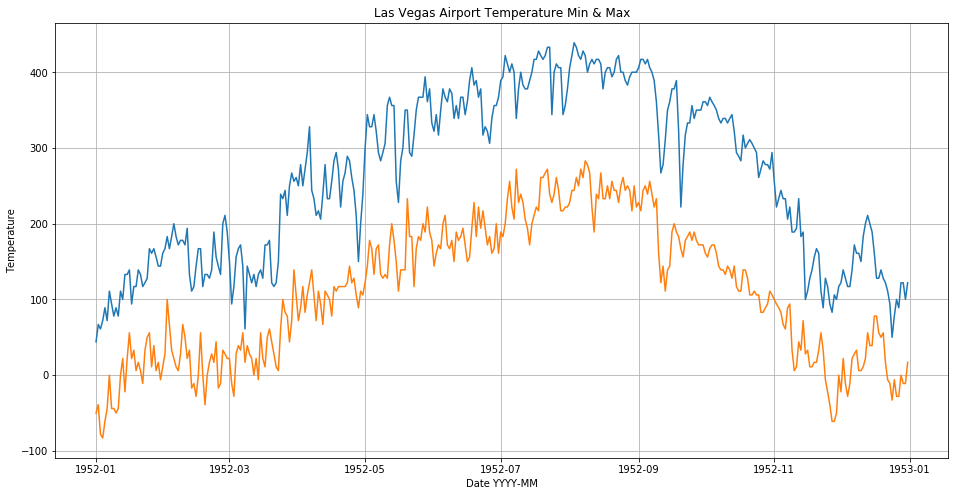

In [16]:
# Plot the data
plt.figure(figsize=(16,8))
plt.plot(vegas_day, vegas_tmin, label = "Min Temp")
plt.plot(vegas_day, vegas_tmax, label = "Max Temp")
plt.xlabel('Date YYYY-MM')
plt.ylabel('Temperature')
plt.title('Las Vegas Airport Temperature Min & Max')
plt.grid(True)
plt.savefig("vegas.png")
plt.show()

### Save the Plot

For these Globus Transfer API interactions we'll be using the transfer token. Also, the Globus Transfer API does not support __[`application/x-www-form-urlencoded`](https://docs.globus.org/api/transfer/overview/#document_formats)__ data so we'll be explicit about the JSON we pass.

At this point, we'll:

1. Activate the endpoint we're using for the tutorial
1. Create a directory for our file
1. `PUT` our plot there
1. Generate a link to our plot and view it

Note, the calls to Transfer can be made via the SDK, with argument validation, etc. For this tutorial we're sticking with direct HTTP request for pedagogical purposes.

In [17]:
# Base URL for the Globus Transfer API
base_url = 'https://transfer.api.globus.org/v0.10'
# ID of the endpoint that we're using for the tutorial
endpoint_uuid = 'e56c36e4-1063-11e6-a747-22000bf2d559'

# Create the header
headers = {'Authorization':'Bearer '+ tokens['tokens']['transfer.api.globus.org']['access_token'],
          "Content-Type" : "application/json"}

In [18]:
# Grab our username (which includes a hash to avoid collision)
username = os.getenv('JUPYTERHUB_USER')
print("My user name is " + username)

My user name is rpwagnermm2gkmjwmu3dellegi3til


In [19]:
# Autoactivate the endpoint
resp = requests.post(base_url + '/endpoint/' + endpoint_uuid + '/autoactivate',
                    headers=headers)
print(resp.status_code)
print(resp.text)

200
{
  "DATA": [], 
  "DATA_TYPE": "activation_result", 
  "code": "AutoActivated.GlobusOnlineCredential", 
  "endpoint": "petrel#testbed", 
  "expire_time": "2018-04-26 14:17:50+00:00", 
  "expires_in": -1, 
  "length": 0, 
  "message": "Endpoint activated successfully using Globus Online credentials.", 
  "oauth_server": null, 
  "request_id": "6KW9WRfS6", 
  "resource": "/endpoint/e56c36e4-1063-11e6-a747-22000bf2d559/autoactivate", 
  "subject": "/C=US/O=Globus Consortium/OU=Globus Connect User/CN=rpwagner"
}


In [20]:
# Call the Transfer API to make the directory
# Note, this will throw a 502 if the directory already exists.
# So don't panic if that happens when you rerun it.
# Later this can be done directly via Collections
mkdir_payload = { "DATA_TYPE": "mkdir",
                  "path": "/test/jhtutorial/users/" + username }

resp = requests.post(base_url + '/endpoint/' + endpoint_uuid + '/mkdir',
                    headers=headers, json=mkdir_payload)
print(resp.status_code)
print(resp.text)

502
{
  "code": "ExternalError.MkdirFailed.Exists", 
  "message": "Path already exists, Error (mkdir)\nEndpoint: petrel#testbed (e56c36e4-1063-11e6-a747-22000bf2d559)\nServer: petreldtn8.pub.jlse.anl.gov:2811\nMessage: Path '/test/jhtutorial/users/rpwagnermm2gkmjwmu3dellegi3til' already exists\n", 
  "request_id": "G3H5wsULq", 
  "resource": "/endpoint/e56c36e4-1063-11e6-a747-22000bf2d559/mkdir"
}


### Put the Plot
This GCS endpoint supports HTTPS and we can `PUT` the plot image file there directly. (If it was larger or many files we might want to use a Transfer request.)

In [21]:
# Create the header
headers = {'Authorization':'Bearer '+ tokens['tokens']['petrel_https_server']['access_token']}

# Pass the file pointer reference to the requests library for the PUT
image_data = open('vegas.png', 'rb')

# Get the user info as JSON
resp = requests.put('https://testbed.petrel.host/test/jhtutorial/users/' + username + '/vegas.png',
                    headers=headers, data=image_data, allow_redirects=False)
print(resp.status_code)

200


### The Link

Let's look at a link to the file. This will require you to authenticate to the GCS endpoint since your browser is a different client than this notebook server.

In [22]:
print('https://testbed.petrel.host/test/jhtutorial/users/' + username + '/vegas.png')

https://testbed.petrel.host/test/jhtutorial/users/rpwagnermm2gkmjwmu3dellegi3til/vegas.png


We can also look at the folders and permissions on the __[shared endpoint](https://www.globus.org/app/transfer?origin_id=e56c36e4-1063-11e6-a747-22000bf2d559&origin_path=%2Ftest%2Fjhtutorial%2F)__